# Initial imports and helper functions

In [152]:
import re
import os
import mne
import math
import scipy.stats
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from mne.viz import plot_compare_evokeds
from mne.time_frequency import tfr_morlet
from mne.channels import find_ch_adjacency
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mne.stats import spatio_temporal_cluster_test, combine_adjacency
from sklearn.preprocessing import StandardScaler

import matplotlib.colors as mc

tab10 = list(mc.TABLEAU_COLORS.values())

In [2]:
event_map = {'Comment/101':101, 
             'Comment/109':109,
             'Comment/30':30,
             'Comment/40':40,
             'Comment/50':50,
             'Comment/51':51,
             'Comment/52':52,
             'Comment/60':60,
             'Comment/70':70,
             'Comment/80':80,
             'New Segment/':99999}

montage = mne.channels.read_custom_montage('./BC-MR3-64.bvef')

In [3]:
# Get active and sham groups from main csv
df = pd.read_csv('../joint/msc_collated_data_20230709.csv')
df = df[["participant_number", "session_type"]].drop_duplicates()

def remove_doubles(x):
    if(x.nunique()==2):
        return 'sham group'
    elif(x.nunique()==1):
        return 'active group'

df["condition"] = df.groupby('participant_number')['session_type'].transform(remove_doubles)
df = df.drop(columns="session_type").drop_duplicates()
df['participant_number'] = df['participant_number'].replace(r'sub-', r'm_', regex=True)

active_ids = df[df.condition=='active group'].participant_number.to_list()
sham_ids = df[df.condition=='sham group'].participant_number.to_list()
# active_ids, sham_ids

In [4]:
# Get list of filenames for each group:
cleaned_dir = './ica_notebooks/cleaned'

active_eeg_files = []
sham_eeg_files = []

for root, dirs, files in os.walk(cleaned_dir):
    for file in files:
        # Actives
        if file.endswith('.vhdr') and any(id in file for id in active_ids):
            active_eeg_files.append(os.path.join(root, file))
        # Sham 
        elif file.endswith('.vhdr') and any(id in file for id in sham_ids):
            sham_eeg_files.append(os.path.join(root, file))

active2bs = []
active2as = []
active1as = []
active1bs = []
sham2bs = []
sham2as = []
sham1as = []
sham1bs = []

# Just look at Posner 2b
for x in active_eeg_files:
    if 'pos2b' in x:
        active2bs.append(x)
    if 'pos1a' in x:
        active1as.append(x)
    if 'pos1b' in x:
        active1bs.append(x)
    if 'pos2a' in x:
        active2as.append(x)
for x in sham_eeg_files:
    if 'pos2b' in x:
        sham2bs.append(x)
    if 'pos1a' in x:
        sham1as.append(x)
    if 'pos1b' in x:
        sham1bs.append(x)
    if 'pos2a' in x:
        sham2as.append(x)

In [18]:
# All Posners tasks over all groups and sessions
all_pos = active2bs+active1as+active2as+active1bs+sham2as+sham2bs+sham1as+sham2bs

# Posners by condition
actives = active2as + active2bs + active1as + active1bs
shams = sham1as + sham1bs + sham2as +sham2bs

# Session only Posner tasks
all2s = active2bs+sham2bs+active2as+sham2as
all1s = active1as+active1bs+sham1as+sham1bs

# First or second only Posner
allbs = active2bs + active1bs + sham2bs + sham1bs
allas = active2as + active1as + sham2as + sham1as

In [9]:
def gather_epochs(file_names, event_ids={'Comment/60':60, 'Comment/70':70}):
    epochs_list = []
    for file in file_names:
        # Load raw
        raw = mne.io.read_raw(file, preload=True)
        print('dropping channel');raw.drop_channels('ECG')
        # Filter ?
        filt_raw = raw.copy().filter(l_freq=3, h_freq=20)
        # Events
        events, event_id = mne.events_from_annotations(filt_raw, event_map) # get events
        # Re-reference
        avg_ref = raw.copy().set_eeg_reference(ref_channels="average")
        # Epoch rejection rule
        reject_criteria=dict(eeg=500e6)
        # Get epochs
        epochs = mne.Epochs(raw=avg_ref, 
                            events=events, 
                            event_id=event_ids, 
                            reject=reject_criteria,
                            detrend=1, 
                            tmin=-0.5, 
                            tmax=2, 
                            # baseline=(-0.5, 0),
                            baseline=(0, None),
                            preload=True,
                            # picks=picks,
                            event_repeated='drop')

        epochs.set_montage(montage)
        epochs_list.append([epochs, file])
        del raw
    return epochs_list

In [14]:
def get_subject_tfr(ep, roi, freqs):
    """Get the mean power over a set of epochs.

    Args:
        ep (mne.Epochs): Epochs in question.
        roi (list): List of strings corresponding to channel picks which are the region of interest.
        freqs (list): List of integer frequency 
    
    Returns:
        float: The mean power for the set of epochs and frequencies.
    """
    tfr_ting = mne.time_frequency.tfr_multitaper(ep, freqs=freqs, n_cycles=freqs/2, picks = roi, return_itc=False)
    power_mean = np.mean(tfr_ting.data, axis=None)
    return power_mean

In [396]:
def get_psd_power_norm(ep, roi, freq_range):
    evoked = ep.average()
    spectrum = evoked.compute_psd('welch', fmin=3, fmax=30, tmin=0, tmax=1, picks=roi)
    psds, freqs = spectrum.get_data(return_freqs=True)
    psds_band = psds[:, (freqs >= freq_range[0]) & (freqs < freq_range[1])].mean(axis=-1)
    psds /= np.sum(psds,axis=-1, keepdims=True) # Normalise
    psds_band_norm = psds[:, (freqs >= freq_range[0]) & (freqs < freq_range[1])].mean(axis=-1)
    return psds_band.mean(), psds_band_norm.mean()

def get_cue_epochs(cue_key, file_names):
    cue_key = [
        ['left',60],
        ['right',70],
        # ['centre',80]
    ]
    cue_epochs = []
    for i in range(len(cue_key)):
        tmp_epochs = gather_epochs(file_names, cue_key[i][1])
        cue_epochs.push(tmp_epochs)

def create_power_table(file_names, iaf_data):
    """Create a table of powers for each eeg file in the list supplied.
    """
    output = {
        'Participant':[],
        'ROI':[],
        'Cue':[],
        'Session':[],
        'Power':[],
        'Normalised Power':[]
    }

    regions = {
        # 'left occipital' : ["O1"],
        # 'right occipital' : ["O2"],
        # 'left parietal-occipital':["PO7", "PO3"],
        # 'right parietal-occipital':["PO8", "PO4"],
        # 'left parietal' : ["P7", "P5", "P3", "P1"],
        # 'right parietal' : ["P2", "P4", "P6", "P8"],
        # 'right O, PO and CP' : ["P2", "P4", "P6", "P8", "PO8", "PO4", "O2", "CP6", "CP4", "CP2"],
        # 'left O, PO and CP' : ["P7", "P5", "P3", "P1", "PO7", "PO3", "O1", "CP5", "CP3", "CP1"],
        'left hemisphere':["P7", "P5", "P3", "P1", "PO7", "PO3", "O1"],
        'right hemisphere':["P2", "P4", "P6", "P8", "PO8", "PO4", "O2"]
    }

    cue_key = [
        ['left',60],
        ['right',70],
        # ['centre',80]
    ]

    freq_roi = {'Alpha': np.arange(8, 12, 1)}

    for i in range(len(cue_key)):
        cue_epochs = gather_epochs(file_names, cue_key[i][1])
        for key, value in regions.items():
            for sub_epochs in cue_epochs:
                sub_id=sub_epochs[1].strip('/ica_notebooks/cleaned/')
                sub_id=re.search(r"/([^/]*)$", sub_id).group(1)
                sub_id=re.findall(r'm_([^_]*)', sub_id)[0]
                session=re.search(r".*pos(\d)\D.*", sub_epochs[1]).group(1)

                ### USE individualised alpha range ###
                # Get iaf and alpha range for subject
                iaf = iaf_data[(iaf_data['Participant']==int(sub_id)) & (iaf_data['Session']==int(session))].IAF.iloc[0]
                print('iaf', iaf)
                a_min = math.floor(iaf - 1)
                a_max = math.ceil(iaf + 1) 
                freq_range = (a_min, a_max)
                ###
                # freq_range = (8, 12)

                epochs=sub_epochs[0]
                # mean_alpha_o, normed_mean_alpha_o = get_psd_power_normed(epochs, value, freq_range)
                mean_alpha, normed_mean_alpha = get_psd_power_norm(epochs, value, freq_range)

                output['Participant'].append(sub_id)
                output['ROI'].append(key)
                output['Power'].append(mean_alpha)
                output['Normalised Power'].append(normed_mean_alpha)
                output['Cue'].append(cue_key[i][0])
                output['Session'].append(session)
    return pd.DataFrame(output)

In [385]:
def get_cue_epochs(file_names):
    """TODO not complete"""
    cue_key = [
        ['left',60],
        ['right',70],
        # ['centre',80]
    ]
    cue_epochs = []
    for i in range(len(cue_key)):
        tmp_epochs = gather_epochs(file_names, cue_key[i][1])
        cue_epochs.append(tmp_epochs)
    return cue_epochs

In [417]:
# Import baseline alpha data
baseline_powers = pd.read_csv('./baseline_powers.csv')
base_ec_powers = baseline_powers[baseline_powers['baseline type']=='baseline_ec']
base_ec_powers['participant'] = base_ec_powers['participant'].astype(int)
base_ec_powers['session'] = base_ec_powers['session'].astype(int)
base_ec_powers = base_ec_powers.drop(columns=['code', 'baseline', 'baseline type', 'time'])
base_ec_powers.rename(columns={'power': 'baseline_power', 'participant':'Participant', 'session':'Session'}, inplace=True)
base_ec_powers

/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/1506380376.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_ec_powers['participant'] = base_ec_powers['participant'].astype(int)
/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/1506380376.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_ec_powers['session'] = base_ec_powers['session'].astype(int)


,Participant,Session,ROI,baseline_power
2,0,1,left hemisphere,0.033111
3,0,1,right hemisphere,0.028484
6,0,2,left hemisphere,0.018791
7,0,2,right hemisphere,0.039199
10,1,2,left hemisphere,0.004663
...,...,...,...,...
159,19,1,right hemisphere,0.185419
162,20,1,left hemisphere,0.256682
163,20,1,right hemisphere,0.393435
166,20,2,left hemisphere,0.030095


In [75]:
# Custom function to determine the 'hemisphere' value
def determine_hemisphere(roi):
    if 'left' in roi:
        return 'left'
    elif 'right' in roi:
        return 'right'
    else:
        return 'unknown'

In [416]:
# Import indivual alpha frequencies
df_iaf = pd.read_csv('./participant_IAF_frequencies.csv')
# Create a new DataFrame for iaf_2 values with session = 2
df_iaf_2 = df_iaf[['IAF_2', 'participant_id']].rename(columns={'IAF_2': 'IAF', 'participant_id': 'Participant'})
df_iaf_2['Session'] = 2

# Create a new DataFrame for iaf_1 values with session = 1
df_iaf_1 = df_iaf[['IAF_1', 'participant_id']].rename(columns={'IAF_1': 'IAF', 'participant_id': 'Participant'})
df_iaf_1['Session'] = 1
df_iaf = pd.concat([df_iaf_2, df_iaf_1], ignore_index=True)
df_iaf.head()

,IAF,Participant,Session
0,10.50,0,2
1,9.25,1,2
2,9.75,2,2
3,10.00,3,2
4,9.50,4,2


In [369]:
powers_test = create_power_table(df_iaf, cued_epochs_all[:2], )
powers_test

iaf 9.75
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.001 (s)
iaf 10.5
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.001 (s)
iaf 9.75
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.001 (s)
iaf 10.5
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.001 (s)
iaf 9.75
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.001 (s)
iaf 10.5
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.001 (s)
iaf 9.75
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.001 (s)
iaf 10.5
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.001 (s)


,Participant,ROI,Cue,Session,Power,Normalised Power
0,09,left hemisphere,left,2,4.489445e-14,0.079651
1,19,left hemisphere,left,2,5.100614e-13,0.181784
2,09,right hemisphere,left,2,2.515234e-14,0.054646
3,19,right hemisphere,left,2,2.710767e-13,0.113253
4,09,left hemisphere,right,2,9.412162e-14,0.140018
5,19,left hemisphere,right,2,2.688161e-13,0.078416
6,09,right hemisphere,right,2,4.312068e-14,0.067410
7,19,right hemisphere,right,2,4.273017e-13,0.155363


In [ ]:
powers_test

# Alpha Comparisons

Here we look at differences in alpha between different regions of interest and in response to different spatially orienting cues during a reaction time task.

In [397]:
powers_all = create_power_table(all_pos, df_iaf)

Extracting parameters from ./ica_notebooks/cleaned/m_09_02/m_09_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 516619  =      0.000 ...   516.619 secs...
dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
28 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 28 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_19_02/m_19_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 686119  =      0.000 ...   686.119 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
38 matching events found
Setting baseline interval to [0.0, 2.0] s


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 38 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_07_02/m_07_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 678635  =      0.000 ...   678.635 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
34 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 34 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_03_02/m_03_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 696262  =      0.000 ...   696.262 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
29 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 29 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_16_02/m_16_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 700376  =      0.000 ...   700.376 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
36 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 36 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_15_02/m_15_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 687590  =      0.000 ...   687.590 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
33 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 33 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_20_02/m_20_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 507628  =      0.000 ...   507.628 secs...
dropping channel

/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)



Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
23 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 23 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_14_02/m_14_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 667933  =      0.000 ...   667.933 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
32 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 32 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_00_02/m_00_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 679689  =      0.000 ...   679.689 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
36 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 36 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_10_02/m_10_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 668899  =      0.000 ...   668.899 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
33 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 33 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_11_01/m_11_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 675030  =      0.000 ...   675.030 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
25 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 25 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_15_01/m_15_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 703100  =      0.000 ...   703.100 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
37 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 37 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_14_01/m_14_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 687981  =      0.000 ...   687.981 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
34 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 34 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_20_01/m_20_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 498570  =      0.000 ...   498.570 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
16 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 16 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_10_01/m_10_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 665561  =      0.000 ...   665.561 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
38 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 38 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_00_01/m_00_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 685731  =      0.000 ...   685.731 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
30 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_19_01/m_19_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 605579  =      0.000 ...   605.579 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
31 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 31 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_09_01/m_09_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 699340  =      0.000 ...   699.340 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
41 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 41 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_07_01/m_07_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 686560  =      0.000 ...   686.560 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
29 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 29 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_03_01/m_03_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 667374  =      0.000 ...   667.374 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
22 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 22 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_16_01/m_16_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 676029  =      0.000 ...   676.029 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
44 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 44 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_09_02/m_09_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 516738  =      0.000 ...   516.738 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
23 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 23 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_07_02/m_07_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 703313  =      0.000 ...   703.313 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


Not setting metadata
38 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 38 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_03_02/m_03_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 667497  =      0.000 ...   667.497 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
43 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 43 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_11_02/m_11_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 675340  =      0.000 ...   675.340 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.8s finished


Not setting metadata
37 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 37 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_15_02/m_15_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 663436  =      0.000 ...   663.436 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
39 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 39 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_20_02/m_20_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 500248  =      0.000 ...   500.248 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
23 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 23 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_14_02/m_14_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 516705  =      0.000 ...   516.705 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
23 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 23 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.4s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_00_02/m_00_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 675588  =      0.000 ...   675.588 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
29 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 29 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_10_02/m_10_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 667992  =      0.000 ...   667.992 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


Not setting metadata
42 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 42 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_11_01/m_11_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 685241  =      0.000 ...   685.241 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
34 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 34 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_15_01/m_15_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 665711  =      0.000 ...   665.711 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
37 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 37 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_14_01/m_14_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 686370  =      0.000 ...   686.370 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
37 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 37 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_20_01/m_20_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 498009  =      0.000 ...   498.009 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
21 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 21 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.4s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_10_01/m_10_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 667363  =      0.000 ...   667.363 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


Not setting metadata
37 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 37 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_00_01/m_00_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 680309  =      0.000 ...   680.309 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
22 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 22 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_19_01/m_19_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 736370  =      0.000 ...   736.370 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
33 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 33 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_09_01/m_09_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 535139  =      0.000 ...   535.139 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
25 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 25 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_07_01/m_07_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 669191  =      0.000 ...   669.191 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
30 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_03_01/m_03_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 673432  =      0.000 ...   673.432 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


Not setting metadata
31 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 31 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_16_01/m_16_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 667352  =      0.000 ...   667.352 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
33 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 33 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_08_02/m_08_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 728771  =      0.000 ...   728.771 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
24 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 24 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_18_02/m_18_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 668340  =      0.000 ...   668.340 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
32 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 32 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_17_02/m_17_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 675771  =      0.000 ...   675.771 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
37 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 37 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_13_02/m_13_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 675770  =      0.000 ...   675.770 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
27 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 27 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_02_02/m_02_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 700777  =      0.000 ...   700.777 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


Not setting metadata
33 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 33 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_12_02/m_12_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 674207  =      0.000 ...   674.207 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
39 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 39 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_06_02/m_06_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 690202  =      0.000 ...   690.202 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


Not setting metadata
35 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 35 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_01_02/m_01_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 687606  =      0.000 ...   687.606 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
32 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 32 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_05_02/m_05_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 681642  =      0.000 ...   681.642 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
35 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 35 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_04_02/m_04_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 679230  =      0.000 ...   679.230 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
25 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 25 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_08_02/m_08_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 508821  =      0.000 ...   508.821 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
31 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 31 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_18_02/m_18_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 660150  =      0.000 ...   660.150 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
21 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 21 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_17_02/m_17_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 699563  =      0.000 ...   699.563 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
30 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_13_02/m_13_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 668631  =      0.000 ...   668.631 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
33 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 33 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_02_02/m_02_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 667422  =      0.000 ...   667.422 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


Not setting metadata
39 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 39 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_12_02/m_12_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 675910  =      0.000 ...   675.910 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
27 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 27 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_01_02/m_01_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 690070  =      0.000 ...   690.070 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
28 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 28 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_05_02/m_05_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 706851  =      0.000 ...   706.851 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
29 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 29 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_04_02/m_04_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 683430  =      0.000 ...   683.430 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
37 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 37 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_01_01/m_01_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 691051  =      0.000 ...   691.051 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
31 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 31 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_05_01/m_05_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 689190  =      0.000 ...   689.190 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
33 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 33 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_04_01/m_04_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 670980  =      0.000 ...   670.980 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
35 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 35 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_18_01/m_18_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 663110  =      0.000 ...   663.110 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
35 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 35 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_08_01/m_08_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 699450  =      0.000 ...   699.450 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
30 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_17_01/m_17_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 671811  =      0.000 ...   671.811 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:    0.6s finished


Not setting metadata
22 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 22 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_13_01/m_13_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 665210  =      0.000 ...   665.210 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
32 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 32 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_12_01/m_12_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 686230  =      0.000 ...   686.230 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


Not setting metadata
28 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 28 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_02_01/m_02_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 680040  =      0.000 ...   680.040 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
28 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 28 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_06_01/m_06_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 689061  =      0.000 ...   689.061 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
35 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 35 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_08_02/m_08_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 508821  =      0.000 ...   508.821 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
31 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 31 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_18_02/m_18_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 660150  =      0.000 ...   660.150 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
21 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 21 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_17_02/m_17_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 699563  =      0.000 ...   699.563 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
30 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_13_02/m_13_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 668631  =      0.000 ...   668.631 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


Not setting metadata
33 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 33 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_02_02/m_02_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 667422  =      0.000 ...   667.422 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


Not setting metadata
39 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 39 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_12_02/m_12_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 675910  =      0.000 ...   675.910 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
27 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 27 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_01_02/m_01_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 690070  =      0.000 ...   690.070 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
28 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 28 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_05_02/m_05_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 706851  =      0.000 ...   706.851 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
29 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 29 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_04_02/m_04_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 683430  =      0.000 ...   683.430 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
37 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 37 events and 2501 original time points ...
0 bad epochs dropped
iaf 9.75
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.001 (s)
iaf 10.5
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.001 (s)
iaf 9.0
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.001 (s)
iaf 10.0
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.001 (s)
iaf 10.5
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.001 (s)
iaf 10.5
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.001 (s)
iaf 1

/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


iaf 10.5
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.001 (s)
iaf 9.75
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.001 (s)
iaf 9.75
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.001 (s)
iaf 9.75
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.001 (s)
iaf 10.5
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.001 (s)
iaf 9.75
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.001 (s)
iaf 9.0
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.001 (s)
iaf 10.0
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.001 (s)
iaf 10.75
NOTE: p

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
27 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 27 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.4s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_19_02/m_19_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 686119  =      0.000 ...   686.119 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
26 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 26 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_07_02/m_07_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 678635  =      0.000 ...   678.635 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
28 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 28 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_03_02/m_03_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 696262  =      0.000 ...   696.262 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
33 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 33 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_16_02/m_16_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 700376  =      0.000 ...   700.376 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
37 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 37 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_15_02/m_15_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 687590  =      0.000 ...   687.590 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
32 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 32 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_20_02/m_20_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 507628  =      0.000 ...   507.628 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


Not setting metadata
30 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_14_02/m_14_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 667933  =      0.000 ...   667.933 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
36 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 36 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_00_02/m_00_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 679689  =      0.000 ...   679.689 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
35 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 35 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_10_02/m_10_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 668899  =      0.000 ...   668.899 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


Not setting metadata
31 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 31 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_11_01/m_11_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 675030  =      0.000 ...   675.030 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
34 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 34 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_15_01/m_15_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 703100  =      0.000 ...   703.100 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
28 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 28 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_14_01/m_14_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 687981  =      0.000 ...   687.981 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
36 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 36 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_20_01/m_20_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 498570  =      0.000 ...   498.570 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
27 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 27 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.4s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_10_01/m_10_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 665561  =      0.000 ...   665.561 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
33 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 33 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_00_01/m_00_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 685731  =      0.000 ...   685.731 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
30 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_19_01/m_19_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 605579  =      0.000 ...   605.579 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


Not setting metadata
23 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 23 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_09_01/m_09_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 699340  =      0.000 ...   699.340 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
36 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 36 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_07_01/m_07_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 686560  =      0.000 ...   686.560 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
33 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 33 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_03_01/m_03_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 667374  =      0.000 ...   667.374 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
37 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 37 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_16_01/m_16_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 676029  =      0.000 ...   676.029 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


Not setting metadata
39 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 39 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_09_02/m_09_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 516738  =      0.000 ...   516.738 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
26 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 26 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_07_02/m_07_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 703313  =      0.000 ...   703.313 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
41 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 41 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_03_02/m_03_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 667497  =      0.000 ...   667.497 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
25 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 25 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_11_02/m_11_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 675340  =      0.000 ...   675.340 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
37 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 37 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_15_02/m_15_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 663436  =      0.000 ...   663.436 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
30 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_20_02/m_20_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 500248  =      0.000 ...   500.248 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
23 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 23 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.4s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_14_02/m_14_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 516705  =      0.000 ...   516.705 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
26 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 26 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_00_02/m_00_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 675588  =      0.000 ...   675.588 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
37 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 37 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_10_02/m_10_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 667992  =      0.000 ...   667.992 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
32 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 32 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_11_01/m_11_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 685241  =      0.000 ...   685.241 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
36 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 36 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_15_01/m_15_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 665711  =      0.000 ...   665.711 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
30 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_14_01/m_14_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 686370  =      0.000 ...   686.370 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
35 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 35 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_20_01/m_20_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 498009  =      0.000 ...   498.009 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
28 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 28 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_10_01/m_10_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 667363  =      0.000 ...   667.363 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
35 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 35 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_00_01/m_00_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 680309  =      0.000 ...   680.309 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
35 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 35 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_19_01/m_19_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 736370  =      0.000 ...   736.370 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
32 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 32 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_09_01/m_09_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 535139  =      0.000 ...   535.139 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
25 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 25 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_07_01/m_07_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 669191  =      0.000 ...   669.191 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.8s finished


Not setting metadata
35 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 35 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_03_01/m_03_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 673432  =      0.000 ...   673.432 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
32 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 32 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_16_01/m_16_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 667352  =      0.000 ...   667.352 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
29 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 29 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_08_02/m_08_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 728771  =      0.000 ...   728.771 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
38 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 38 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_18_02/m_18_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 668340  =      0.000 ...   668.340 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
36 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 36 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_17_02/m_17_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 675771  =      0.000 ...   675.771 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
32 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 32 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_13_02/m_13_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 675770  =      0.000 ...   675.770 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
40 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 40 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_02_02/m_02_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 700777  =      0.000 ...   700.777 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
36 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 36 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_12_02/m_12_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 674207  =      0.000 ...   674.207 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
37 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 37 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_06_02/m_06_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 690202  =      0.000 ...   690.202 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
35 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 35 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_01_02/m_01_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 687606  =      0.000 ...   687.606 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
36 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 36 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_05_02/m_05_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 681642  =      0.000 ...   681.642 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
29 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 29 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_04_02/m_04_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 679230  =      0.000 ...   679.230 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


Not setting metadata
45 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 45 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_08_02/m_08_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 508821  =      0.000 ...   508.821 secs...
dropping channel


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
23 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 23 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.4s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_18_02/m_18_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 660150  =      0.000 ...   660.150 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
27 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 27 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_17_02/m_17_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 699563  =      0.000 ...   699.563 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
25 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 25 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_13_02/m_13_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 668631  =      0.000 ...   668.631 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
37 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 37 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_02_02/m_02_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 667422  =      0.000 ...   667.422 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
29 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 29 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_12_02/m_12_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 675910  =      0.000 ...   675.910 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
48 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_01_02/m_01_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 690070  =      0.000 ...   690.070 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
35 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 35 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_05_02/m_05_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 706851  =      0.000 ...   706.851 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
28 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 28 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_04_02/m_04_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 683430  =      0.000 ...   683.430 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
42 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 42 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_01_01/m_01_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 691051  =      0.000 ...   691.051 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
30 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_05_01/m_05_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 689190  =      0.000 ...   689.190 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
27 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 27 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_04_01/m_04_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 670980  =      0.000 ...   670.980 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
25 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 25 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_18_01/m_18_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 663110  =      0.000 ...   663.110 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
34 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 34 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_08_01/m_08_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 699450  =      0.000 ...   699.450 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
38 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 38 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_17_01/m_17_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 671811  =      0.000 ...   671.811 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:    0.6s finished


Not setting metadata
40 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 40 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_13_01/m_13_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 665210  =      0.000 ...   665.210 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


Not setting metadata
36 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 36 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_12_01/m_12_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 686230  =      0.000 ...   686.230 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
30 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_02_01/m_02_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 680040  =      0.000 ...   680.040 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
37 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 37 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_06_01/m_06_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 689061  =      0.000 ...   689.061 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
37 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 37 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_08_02/m_08_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 508821  =      0.000 ...   508.821 secs...
dropping channel

/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)



Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
23 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 23 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.4s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_18_02/m_18_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 660150  =      0.000 ...   660.150 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
27 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 27 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_17_02/m_17_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 699563  =      0.000 ...   699.563 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
25 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 25 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_13_02/m_13_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 668631  =      0.000 ...   668.631 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
37 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 37 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_02_02/m_02_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 667422  =      0.000 ...   667.422 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
29 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 29 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_12_02/m_12_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 675910  =      0.000 ...   675.910 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
48 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_01_02/m_01_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 690070  =      0.000 ...   690.070 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
35 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 35 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_05_02/m_05_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 706851  =      0.000 ...   706.851 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
28 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 28 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_04_02/m_04_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 683430  =      0.000 ...   683.430 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
42 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 42 events and 2501 original time points ...
0 bad epochs dropped
iaf 9.75


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_17306/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.001 (s)
iaf 10.5
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.001 (s)
iaf 9.0
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.001 (s)
iaf 10.0
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.001 (s)
iaf 10.5
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.001 (s)
iaf 10.5
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.001 (s)
iaf 11.0
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.001 (s)
iaf 8.75
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.001 (s)
iaf 10.5
NOTE: pick_channe

In [398]:
powers_all['Participant'] = powers_all['Participant'].astype(int)
powers_all['Session'] = powers_all['Session'].astype(int)

In [418]:
powers_baselines = pd.merge(powers_all, base_ec_powers, on=['Participant', 'ROI', 'Session'])
powers_baselines['Baselined Power'] = powers_baselines['Normalised Power'] - powers_baselines['baseline_power']
powers_baselines['hemisphere'] = powers_baselines['ROI'].apply(determine_hemisphere)
powers_baselines

,Participant,ROI,Cue,Session,Power,Normalised Power,baseline_power,Baselined Power,hemisphere
0,9,left hemisphere,left,2,5.477275e-14,0.097228,0.322296,-0.225068,left
1,9,left hemisphere,left,2,1.076800e-14,0.022648,0.322296,-0.299648,left
2,9,left hemisphere,right,2,1.170210e-13,0.173097,0.322296,-0.149199,left
3,9,left hemisphere,right,2,5.266686e-14,0.126013,0.322296,-0.196283,left
4,19,left hemisphere,left,2,6.691020e-13,0.234193,0.048896,0.185296,left
...,...,...,...,...,...,...,...,...,...
311,12,right hemisphere,right,1,6.398936e-15,0.008827,0.190456,-0.181629,right
312,2,right hemisphere,left,1,5.753695e-14,0.076309,0.056173,0.020136,right
313,2,right hemisphere,right,1,2.466035e-13,0.225690,0.056173,0.169517,right
314,6,right hemisphere,left,1,1.902213e-14,0.060375,0.027491,0.032885,right


## None baselined power comparisons

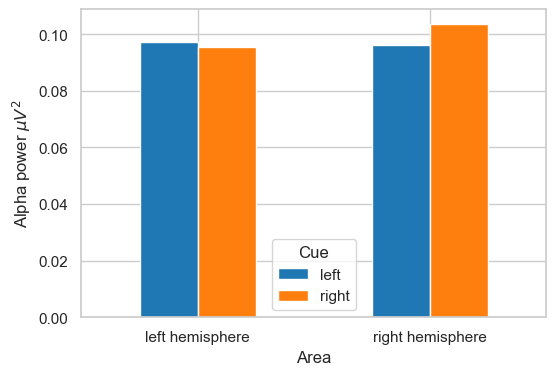

In [419]:
powers_grouped = powers_all.groupby(['ROI', 'Cue'])['Normalised Power'].mean().reset_index()

powers_pivot = powers_grouped.pivot(index='ROI', columns='Cue', values='Normalised Power')
powers_pivot.plot(kind='bar', figsize=(6, 4), color=tab10)

plt.ylabel(r'Alpha power $\mu V^{2}$')
plt.xlabel('Area')
plt.xticks(rotation=0)
# plt.ylim(-1.6e-17, 1.5e-17)
plt.show()

## Raw power

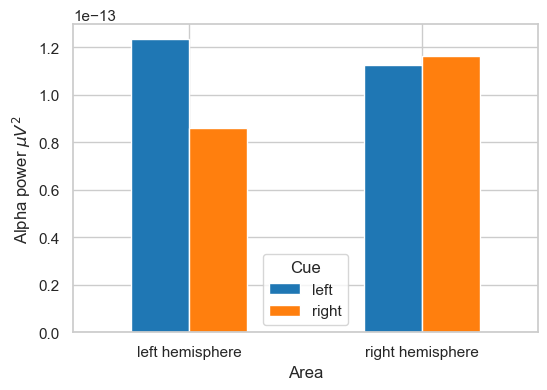

In [420]:
powers_grouped = powers_all.groupby(['ROI', 'Cue'])['Power'].mean().reset_index()

powers_pivot = powers_grouped.pivot(index='ROI', columns='Cue', values='Power')
powers_pivot.plot(kind='bar', figsize=(6, 4), color=tab10)

plt.ylabel(r'Alpha power $\mu V^{2}$')
plt.xlabel('Area')
plt.xticks(rotation=0)
# plt.ylim(-1.6e-17, 1.5e-17)
plt.show()

In [405]:
import scipy.stats as stats
# Get unique ROIs
df = powers_baselines
unique_rois = df['ROI'].unique()
results = []

for roi in unique_rois:
    # Filter data for specific ROI
    roi_df = df[df['ROI'] == roi]
    
    # Split data based on cue
    left_cue = roi_df[roi_df['Cue'] == 'left']['Power']
    right_cue = roi_df[roi_df['Cue'] == 'right']['Power']
    
    # Perform t-test
    t_stat, p_value = stats.ttest_ind(left_cue, right_cue)
    
    # Store results
    results.append((roi, t_stat, p_value, left_cue.mean(), right_cue.mean()))

# Convert results into DataFrame for easier visualization
results_df = pd.DataFrame(results, columns=['ROI', 'T-statistic', 'p-value', 'Mean Left', 'Mean Right'])
results_df

,ROI,T-statistic,p-value,Mean Left,Mean Right
0,left hemisphere,1.543282,0.124789,1.236046e-13,8.602722e-14
1,right hemisphere,-0.169771,0.865410,1.124557e-13,1.162031e-13


## Baselined power comparisons

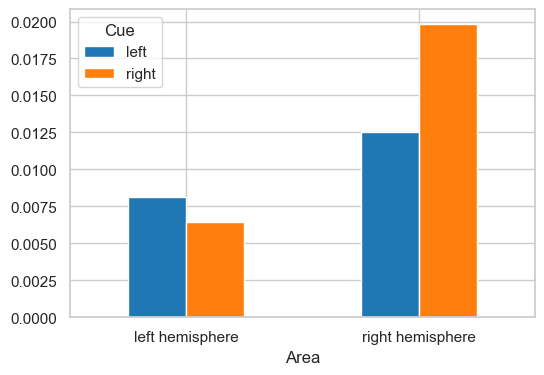

In [421]:
powers_grouped = powers_baselines.groupby(['ROI', 'Cue'])['Baselined Power'].mean().reset_index()

# powers_grouped = powers_grouped[~powers_grouped['ROI'].isin(['left O, PO and CP', 'right O, PO and CP'])]
# powers_grouped = powers_grouped[powers_grouped['ROI'].isin(['left hemisphere', 'right hemisphere'])]

powers_pivot = powers_grouped.pivot(index='ROI', columns='Cue', values='Baselined Power')
powers_pivot.plot(kind='bar', figsize=(6, 4), color=tab10)

# plt.ylabel(r'Alpha power $\mu V^{2}$')
plt.xlabel('Area')
plt.xticks(rotation=0)
# plt.ylim(1e-12, 3.6e-12)
plt.show()

In [422]:
import scipy.stats as stats
# Get unique ROIs
df = powers_baselines
unique_rois = df['ROI'].unique()
results = []

for roi in unique_rois:
    # Filter data for specific ROI
    roi_df = df[df['ROI'] == roi]
    
    # Split data based on cue
    left_cue = roi_df[roi_df['Cue'] == 'left']['Baselined Power']
    right_cue = roi_df[roi_df['Cue'] == 'right']['Baselined Power']
    
    # Perform t-test
    t_stat, p_value = stats.ttest_ind(left_cue, right_cue)
    
    # Store results
    results.append((roi, t_stat, p_value, left_cue.mean(), right_cue.mean()))

# Convert results into DataFrame for easier visualization
results_df = pd.DataFrame(results, columns=['ROI', 'T-statistic', 'p-value', 'Mean Left', 'Mean Right'])
results_df

,ROI,T-statistic,p-value,Mean Left,Mean Right
0,left hemisphere,0.106658,0.915198,0.008164,0.006411
1,right hemisphere,-0.468178,0.640311,0.012533,0.019837


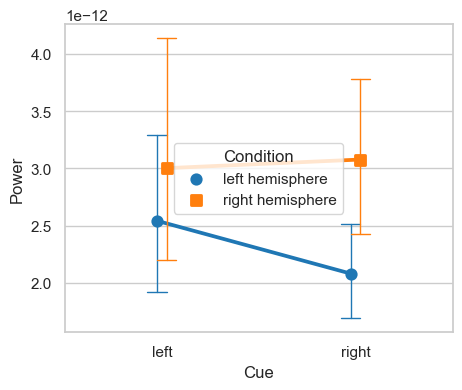

,Participant,ROI,Cue,Session,Power,Normalised Power,baseline_power,Baselined Power,hemisphere,Baselined Power Normalised
0,9,left hemisphere,left,2,1.625881e-12,1.027145e-16,-4.678797e-16,1.626349e-12,left,5.705942e-16
1,9,left hemisphere,left,2,1.285513e-12,2.206654e-17,-4.678797e-16,1.285981e-12,left,4.899462e-16
2,9,left hemisphere,right,2,1.741089e-12,3.759485e-17,-4.678797e-16,1.741557e-12,left,5.054746e-16
3,9,left hemisphere,right,2,1.198958e-12,-6.506802e-17,-4.678797e-16,1.199426e-12,left,4.028117e-16
4,19,left hemisphere,left,2,1.677576e-11,-5.342427e-17,-5.075305e-16,1.677627e-11,left,4.541063e-16
...,...,...,...,...,...,...,...,...,...,...
311,12,right hemisphere,right,1,1.126708e-12,-9.022765e-17,-3.013462e-16,1.127009e-12,right,2.111186e-16
312,2,right hemisphere,left,1,1.557017e-12,5.437827e-17,2.220446e-16,1.556795e-12,right,-1.676663e-16
313,2,right hemisphere,right,1,2.230432e-12,6.858521e-17,2.220446e-16,2.230210e-12,right,-1.534594e-16
314,6,right hemisphere,left,1,4.949558e-13,-1.691768e-16,-2.379049e-16,4.951937e-13,right,6.872809e-17


In [244]:
df_o = powers_baselines.copy()
# df_o = df_o[df_o['ROI'].isin(['left parietal-occipital', 'right parietal-occipital'])]
# df_o = df_o[df_o['ROI'].isin(['left parietal-occipital', 'right parietal-occipital'])]
# df_o['ROI'] = df_o['ROI'].replace({'left O, PO and CP': 'Left hemisphere', 'right O, PO and CP': 'Right hemisphere'})

# Interaction plot for session_type and task with respect to key_resp.rt
sns.set(style="whitegrid")
plt.figure(figsize=(5, 4))
interaction_plot = sns.pointplot(x='Cue', y='Power', hue='ROI', data=df_o, dodge=True, markers=['o', 's'], capsize=.1, errwidth=1, palette='tab10')

plt.legend(title='Condition')
plt.show()
df_o

## Normalised power comparisons

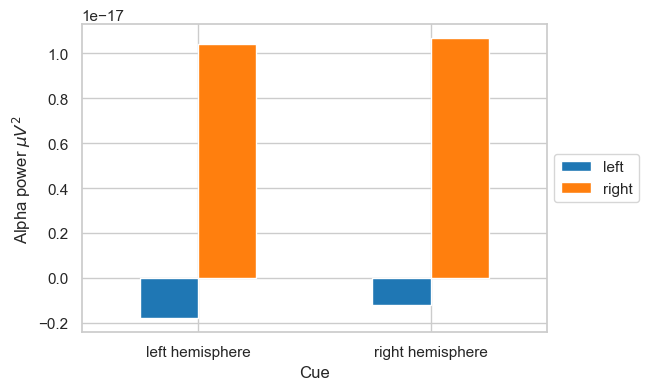

In [248]:
powers_grouped = powers_baselines.groupby(['ROI', 'Cue', 'hemisphere'])['Normalised Power'].mean().reset_index()
powers_pivot = powers_grouped.pivot(index='ROI', columns='Cue', values='Normalised Power')
powers_pivot.plot(kind='bar', figsize=(6, 4), color=tab10)

plt.ylabel(r'Alpha power $\mu V^{2}$')
plt.xlabel('Cue')
plt.xticks(rotation=0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [243]:
import scipy.stats as stats
# Get unique ROIs
df = powers_baselines
unique_rois = df['ROI'].unique()
results = []

for roi in unique_rois:
    # Filter data for specific ROI
    roi_df = df[df['ROI'] == roi]
    
    # Split data based on cue
    left_cue = roi_df[roi_df['Cue'] == 'left']['Normalised Power']
    right_cue = roi_df[roi_df['Cue'] == 'right']['Normalised Power']
    
    # Perform t-test
    t_stat, p_value = stats.ttest_ind(left_cue, right_cue)
    
    # Store results
    results.append((roi, t_stat, p_value, left_cue.mean(), right_cue.mean()))

# Convert results into DataFrame for easier visualization
results_df = pd.DataFrame(results, columns=['ROI', 'T-statistic', 'p-value', 'Mean Left', 'Mean Right'])
results_df

,ROI,T-statistic,p-value,Mean Left,Mean Right
0,left hemisphere,-1.105241,0.270757,-1.792264e-18,1.042852e-17
1,right hemisphere,-1.014585,0.311875,-1.222678e-18,1.067022e-17


## Normalised and baselined power

In [337]:
# scaler = StandardScaler()
# power_column = powers_baselines['Baselined Power'].values.reshape(-1, 1)
# normalized_power = scaler.fit_transform(power_column)
# powers_baselines['Power Norm Baselined'] = normalized_power
powers_baselines['Baselined Power Normalised'] = powers_baselines['Normalised Power'] - powers_baselines['baseline_power']


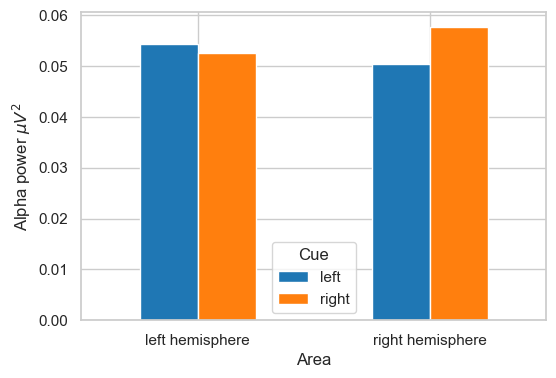

In [338]:
powers_grouped = powers_baselines.groupby(['ROI', 'Cue'])['Baselined Power Normalised'].mean().reset_index()

# powers_grouped = powers_grouped[~powers_grouped['ROI'].isin(['left occipital', 'right occipital'])]

powers_pivot = powers_grouped.pivot(index='ROI', columns='Cue', values='Baselined Power Normalised')
powers_pivot.plot(kind='bar', figsize=(6, 4), color=tab10)

plt.ylabel(r'Alpha power $\mu V^{2}$')
plt.xlabel('Area')
plt.xticks(rotation=0)
# plt.ylim(1e-12, 3.6e-12)
plt.show()